In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## The Problem:

$ y = Bernoulli(sigmoid(slope * x + intercept)) $

where

$ x \sim Normal(mu, sigma) $

Ex: x - age, y - have gray hair.

# True Model and Observations

In [39]:
N = 200

slope = 0.1
intercept = -4

mu_age = 39
sigma_age = 12

x = tfd.Normal(mu_age, sigma_age).sample(N)

logits = slope * x + intercept
probability_gray_hair = tf.math.sigmoid(logits)

y = tfd.Bernoulli(probs=probability_gray_hair).sample()

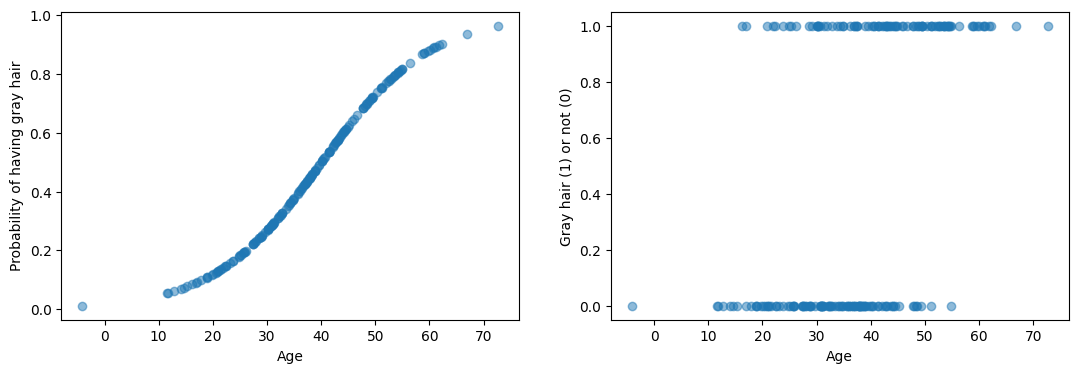

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
axs = axs.flat

axs[0].scatter(x, probability_gray_hair, alpha=0.5)
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Probability of having gray hair")

axs[1].scatter(x, y, alpha=0.5)
axs[1].set_xlabel("Age")
axs[1].set_ylabel("Gray hair (1) or not (0)")

plt.show()

# Variational Inference (Mean Field)

parameters:
- mu_age
- mu_sigma
- slope
- intercept

Comments: 

- Using the Root wrapper is optional. It helps to mark the rand vars that are not conditioned on any other rvs in the model.



In [99]:
def get_surrogate():
    return tfd.JointDistributionSequentialAutoBatched([
            tfd.Normal(
                loc=tf.Variable(40., name='q_mu_age_loc'),
                scale=tfp.util.TransformedVariable(10., bijector=tfb.Softplus(), name='q_mu_age_scale'), name='q_mu_age'),

            #tfd.HalfNormal(
            #    scale=tfp.util.TransformedVariable(10., bijector=tfb.Softplus(), name='q_sigma_age_scale')),
            tfd.LogNormal(
                loc=tf.Variable(1., name='q_sigma_age_loc'),
                scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_sigma_age_scale'), name='q_sigma_age'),

            tfd.Normal(
                loc=tf.Variable(0., name='q_slope_loc'),
                scale=tfp.util.TransformedVariable(0.5, bijector=tfb.Softplus(), name='q_slope_scale'), name='q_slope'),

            tfd.Normal(
                loc=tf.Variable(-3., name='q_intercept_loc'),
                scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_intercept_scale'), name='q_intercept')
        ])

surrogate = get_surrogate()

print('Trainable variables. Surrogate')
for i, v in enumerate(surrogate.trainable_variables):
    print(i, ':', v)
    


# set N sampels and gerenate accordingly 
generative_model = tfd.JointDistributionSequentialAutoBatched([
    # All of these have the shape of the sample
    tfd.Normal(loc=40., scale=10., name='mu_age'),    
    #tfd.HalfNormal(scale=1., name='sigma_age'),
    tfd.LogNormal(loc=5., scale=1., name='sigma_age'),
    tfd.Normal(loc=0., scale=1., name='slope'), 
    tfd.Normal(loc=-3., scale=1., name='intercept'),
    # Here we need to broadcast correctly..
    # We need to make sure that age matches the observation number. Here I have hardcoded N, but theres probably cleaner ways of doing it.
    lambda intercept, slope, sigma_age, mu_age: tfd.Normal(loc=mu_age*tf.ones(N), scale=sigma_age, name='age'),  # age
    #  Note: Using logits works. Using params results in -inf
    lambda age, intercept, slope: tfd.Bernoulli(logits=slope * x + intercept, name='gray_hair')  # gray_hair# probs=tf.math.sigmoid(slope * x + intercept)
])

# Define the target_log_prob_fn
target_log_prob_fn = lambda mu_age, sigma_age, slope, intercept: tf.reduce_sum(generative_model.log_prob([mu_age, sigma_age, slope, intercept, x, y])) #, y



print('\nExamples log probs (sample)')
sample = surrogate.sample(5)
for i in sample:
    print(i)
#print(target_log_prob_fn(*sample[::-1]).numpy())
print('target_log_prob_fn', target_log_prob_fn(*sample).numpy())
print(surrogate.log_prob(sample ).numpy())

print()

Trainable variables. Surrogate
0 : <tf.Variable 'q_mu_age_loc:0' shape=() dtype=float32, numpy=40.0>
1 : <tf.Variable 'q_mu_age_scale:0' shape=() dtype=float32, numpy=9.999954>
2 : <tf.Variable 'q_sigma_age_loc:0' shape=() dtype=float32, numpy=1.0>
3 : <tf.Variable 'q_sigma_age_scale:0' shape=() dtype=float32, numpy=0.54132485>
4 : <tf.Variable 'q_slope_loc:0' shape=() dtype=float32, numpy=0.0>
5 : <tf.Variable 'q_slope_scale:0' shape=() dtype=float32, numpy=-0.43275213>
6 : <tf.Variable 'q_intercept_loc:0' shape=() dtype=float32, numpy=-3.0>
7 : <tf.Variable 'q_intercept_scale:0' shape=() dtype=float32, numpy=0.54132485>

Examples log probs (sample)
tf.Tensor([46.692627 41.021328 48.725967 54.50995  41.941074], shape=(5,), dtype=float32)
tf.Tensor([1.5851216 4.087618  5.7175155 2.7890759 8.394813 ], shape=(5,), dtype=float32)
tf.Tensor([-0.7342682  -0.12780872 -0.24240808 -0.133149    0.7760881 ], shape=(5,), dtype=float32)
tf.Tensor([-3.3842623 -1.9600397 -2.8453307 -5.0984945 -2.388

In [100]:
[i.shape for i in generative_model.sample(5)]

[TensorShape([5]),
 TensorShape([5]),
 TensorShape([5]),
 TensorShape([5]),
 TensorShape([5, 200]),
 TensorShape([5, 200])]

In [101]:
generative_model.log_prob_parts(sample + [x, y])

[<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-3.44548  , -3.2267394, -3.6022363, -4.274217 , -3.2403626],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-11.682399,  -8.778269,  -7.964757,  -9.842137,  -7.171853],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-1.1885134 , -0.927106  , -0.9483194 , -0.92780286, -1.2200949 ],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-0.9927673, -1.4596972, -0.9308998, -3.120778 , -1.1056173],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-9709.842 , -1460.0585, -1383.2217, -6046.89  ,  -855.2427],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-3381.9954,  -719.6737, -1280.6807, -1039.27  , -2358.5056],
       dtype=float32)>]

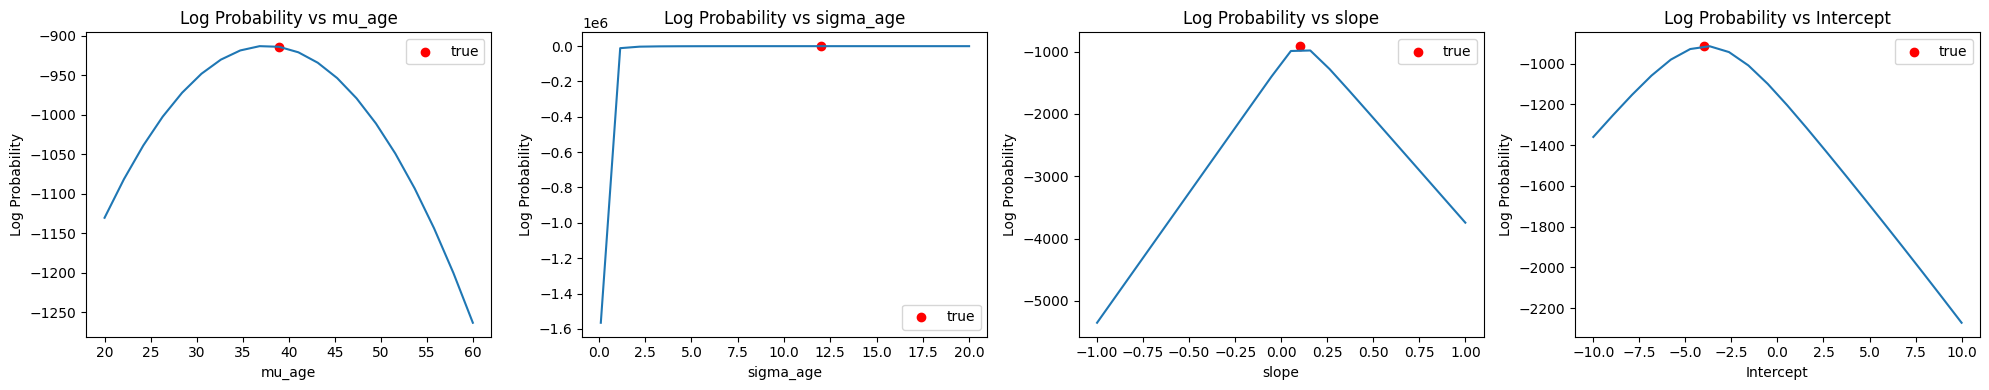

In [102]:

# marginal log prob plots given corrct data in the other

n_linspace = 20

fig, axs = plt.subplots(1, 4, figsize=(20, 4))

# mu_age 
mu_age_linspace = np.linspace(20, 60, n_linspace)
logprobs_mu_age = [target_log_prob_fn(mu_i, sigma_age, slope, intercept) for mu_i in mu_age_linspace]

axs[0].plot(mu_age_linspace, logprobs_mu_age)
axs[0].scatter(mu_age, target_log_prob_fn(mu_age, sigma_age, slope, intercept), color='red', label='true')
axs[0].set_xlabel("mu_age")
axs[0].set_ylabel("Log Probability")
axs[0].legend()
axs[0].set_title("Log Probability vs mu_age")

# sigma_age
sigma_age_linspace = np.linspace(0.1, 20, n_linspace)
logprobs_sigma_age = [target_log_prob_fn(mu_age, sigma_i, slope, intercept) for sigma_i in sigma_age_linspace]

axs[1].plot(sigma_age_linspace, logprobs_sigma_age)
axs[1].scatter(sigma_age, target_log_prob_fn(mu_age, sigma_age, slope, intercept), color='red', label='true')
axs[1].set_xlabel("sigma_age")
axs[1].set_ylabel("Log Probability")
axs[1].legend()
axs[1].set_title("Log Probability vs sigma_age")

# Slope plot
slope_linspace = np.linspace(-1, 1, n_linspace)
logprobs_slope = [target_log_prob_fn(mu_age, sigma_age, slope_i, intercept) for slope_i in slope_linspace]

axs[2].plot(slope_linspace, logprobs_slope)
axs[2].scatter(slope, target_log_prob_fn(mu_age, sigma_age, slope, intercept), color='red', label='true')
axs[2].set_xlabel("slope")
axs[2].set_ylabel("Log Probability")
axs[2].legend()
axs[2].set_title("Log Probability vs slope")

# Intercept 
intercept_linspace = np.linspace(-10, 10, n_linspace)
logprobs_intercept = [target_log_prob_fn(mu_age, sigma_age, slope, intercept_i) for intercept_i in intercept_linspace]

axs[3].plot(intercept_linspace, logprobs_intercept)
axs[3].scatter(intercept, target_log_prob_fn(mu_age, sigma_age, slope, intercept), color='red', label='true')
axs[3].set_xlabel("Intercept")
axs[3].set_ylabel("Log Probability")
axs[3].legend()
axs[3].set_title("Log Probability vs Intercept")

plt.tight_layout()

**Looks good?**

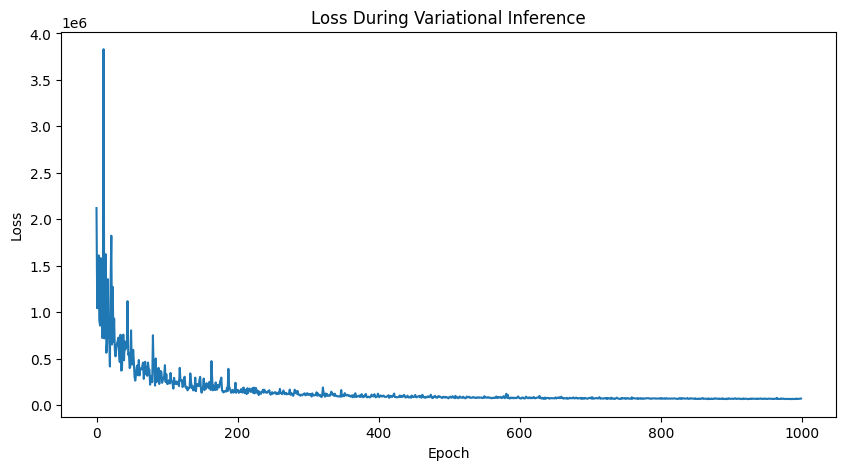

In [103]:
num_steps = 1000
sample_size = 64
learning_rate = 0.01

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=target_log_prob_fn,
    surrogate_posterior=surrogate,
    optimizer=optimizer,
    num_steps=num_steps,
    sample_size=sample_size
)

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss During Variational Inference")
plt.show()

In [104]:
surr_params = np.mean(surrogate.sample(1000), axis=1)

In [105]:
surr_params

array([39.102818  , 14.658128  ,  0.11393132, -4.3413897 ], dtype=float32)

In [106]:
print('True params')
print('mu_age', mu_age)
print('sigma_age', sigma_age)
print('slope', slope)
print('intercept', intercept)

True params
mu_age 39
sigma_age 12
slope 0.1
intercept -4


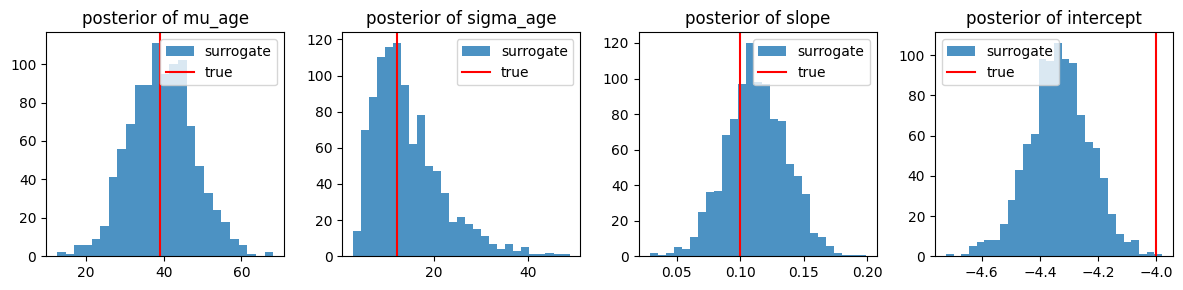

In [107]:

samples = surrogate.sample(1000)


plt.figure(figsize=(12, 3))
for i, param in enumerate(['mu_age', 'sigma_age', 'slope', 'intercept']):
    plt.subplot(1, 4, i+1)
    plt.hist(samples[i].numpy(), bins='auto', alpha=0.8, label='surrogate')
    plt.axvline([mu_age, sigma_age, slope, intercept][i], color='red', label='true')
    plt.title(f'posterior of {param}')
    plt.legend()
plt.tight_layout()
plt.show()
 

Some notes:
- Its possible to improve the intercept result by tweaking the priors
- I needed to enforce correct size in the generative model using *tf.ones(N) for age dist
- Using logits works for Bernoulli in generative works better than prob. Using prob results in -inf